In [1]:
import sys
sys.path.insert(0, '/root/conda/lib/python3.9/site-packages')

In [2]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [4]:
n_clusters = 6
n_samples = 250

In [5]:
centroids = torch.rand(n_clusters, 2)*70-35

In [6]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [7]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [8]:
def sample(c): return MultivariateNormal(c, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [9]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

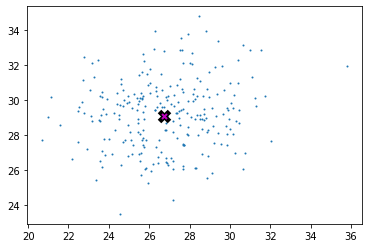

In [10]:
_,ax = plt.subplots()
samples = data[0:n_samples]
samples.shape
ax.scatter(samples[:,0], samples[:,1], s=1)
ax.plot(*centroids[0], markersize=10, marker='x', color='k', mew=5)
ax.plot(*centroids[0], markersize=5, marker='x', color='m', mew=2)

In [11]:
def plot_data(data, centroids, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[(i*n_samples):(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='m', mew=2)

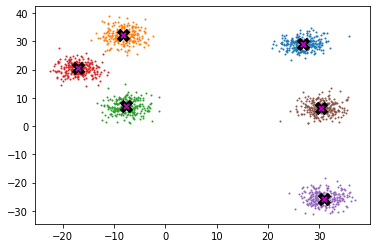

In [12]:
plot_data(data, centroids, n_samples)

In [13]:
midp = data.mean(0); midp

tensor([ 9.222, 11.604])

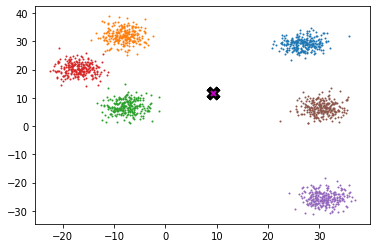

In [14]:
plot_data(data, [midp]*6, n_samples)

In [15]:
def gaussian(d, bw): return torch.exp(-0.5*(d/bw)**2) / (bw * torch.sqrt(tensor(2)*torch.pi))

In [16]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

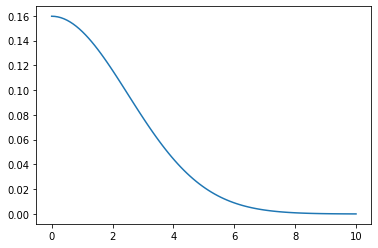

In [17]:
plot_func(partial(gaussian, bw=2.5))

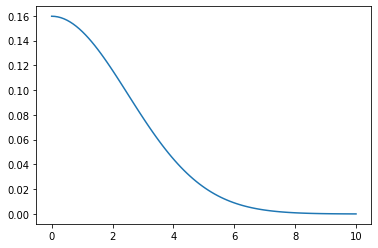

In [18]:
plot_func(lambda x: gaussian(x, bw=2.5))

In [19]:
def tri(d, i): return (-d + i).clamp_min(0)/i

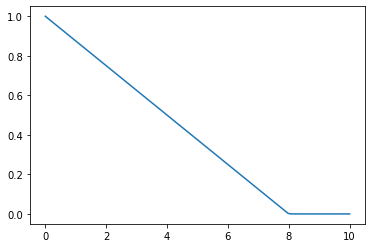

In [20]:
plot_func(partial(tri, i=8))

In [21]:
X = data.clone()
x = X[0]

In [22]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [23]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [24]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [25]:
d = torch.einsum('j,ij->ij',x,torch.ones_like(X)) - X
d[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [26]:
d2 = torch.sqrt(torch.einsum('ij,ij->i',d,d))
d2[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [27]:
((x-X)).sum(1)[:8]

tensor([ 0.000, -3.352, -6.572, -3.128, -8.777, -4.711, -9.016, -7.606])

In [28]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [29]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [30]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [31]:
X[0]*weight[0]

tensor([4.182, 4.205])

In [32]:
(X*weight[:,None]).sum(0)/weight.sum()

tensor([26.440, 28.038])

In [33]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weights = gaussian(dist, 2.5)
        #weights = tri(dist, 8)
        X[i] = (weights[:,None]*X).sum(0)/weights.sum()

In [34]:
def meanshift(data):
    X = data.clone()
    for _ in range(5):
        one_update(X)
    return X

In [35]:
%time X = meanshift(data)

CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s


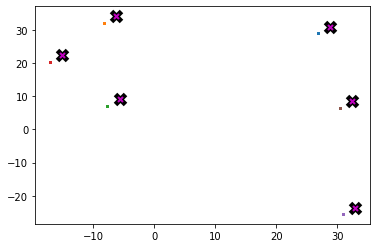

In [36]:
plot_data(X, centroids+2, n_samples)

In [37]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [38]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(X, centroids + 2, n_samples, ax=ax)

In [39]:
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [40]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [41]:
dist = (x[:,None]-X[None,:]).sum(2)
dist.shape, dist

(torch.Size([5, 1500]),
 tensor([[ 0.000, -3.352, -6.572,  ..., 12.457, 19.238, 16.076],
         [ 3.352,  0.000, -3.221,  ..., 15.809, 22.590, 19.428],
         [ 6.572,  3.221,  0.000,  ..., 19.029, 25.811, 22.648],
         [ 3.128, -0.224, -3.445,  ..., 15.585, 22.366, 19.203],
         [ 8.777,  5.426,  2.205,  ..., 21.234, 28.016, 24.853]]))

In [42]:
def dist(a,b): return (((a[:,None]-b[None])**2).sum(2)).sqrt()

In [43]:
dist(x, X)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [44]:
weights = gaussian(dist(x, X), bw=2)
weights

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [45]:
weights.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [46]:
weights[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [47]:
num = (weights[...,None]*X[None]).sum(1)

In [48]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [49]:
torch.einsum('ij,jk->ik',weights,X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [50]:
weights@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [51]:
div = weights.sum(1, keepdim=True)
div

tensor([[13.947],
        [19.859],
        [11.410],
        [20.238],
        [ 7.888]])

In [52]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [53]:
def meanshift(data, bs=500):
    X = data.clone()
    n = len(data)
    for _ in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(i+bs,n))
            d = dist(X[s], X)
            weights = gaussian(d, bw=2)
            div = weights.sum(1, keepdim=True)
            X[s] = weights@X/div
    return X

In [54]:
data = data.cuda()

In [55]:
X = meanshift(data).cpu()

In [56]:
%timeit -n 5 _=meanshift(data, 1500).cpu()

5.44 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
